In [1]:
import pandas as pd
import re
import string
# from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
from nltk.probability import FreqDist
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import sparse 
import numpy as np

In [2]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [4]:
data_df2 = pd.read_csv("./preprocessed_data/fitness_response_preprocssed_Lem_stopwords_removal1.csv")

In [5]:
data_df2.head()

,Unnamed: 0,op_id,op_gender,post_id,responder_id,response_text,responder_gender,response_text_cleaned,response_text_cleaned1
0,0,102,W,0,1196122,One day at a time! =],M,one day time! =],"['one', 'day', 'time!', '=]']"
1,1,104,W,1,5867,Crazy is synonymous with awesome in this case.,W,crazy synonymous awesome case.,"['crazy', 'synonymous', 'awesome', 'case.']"
2,2,104,W,2,1635,You can enter assisted pullups. Select pullups...,M,enter assisted pullups. select pullups normall...,"['enter', 'assisted', 'pullups.', 'select', 'p..."
3,3,117,M,3,8520,"Mirin 3% bodyfat? Yeah, you are.",W,"mirin % bodyfat? yeah, are.","['mirin', '%', 'bodyfat?', 'yeah,', 'are.']"
4,4,117,M,4,29126,"Hey! I just started a new job, so things are s...",M,"hey! started new job, thing sorta hectic. let ...","['hey!', 'started', 'new', 'job,', 'thing', 's..."


In [6]:
data_df2 = data_df2[~ data_df2['response_text_cleaned'].isna()]

In [26]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_df2['response_text_cleaned'])
features = vectorizer.get_feature_names_out()
y = data_df2['op_gender']

In [8]:
X.shape

(317577, 53501)

In [9]:
print(features[:30])

['__' '___' '____' '_____' '______' '_______' '________' '__________'
 '______________' '__________________' '________________________' '__it'
 '_and_' '_c' '_corona' '_definitely_' '_do_' '_everyday' '_have_' '_hot_'
 '_i_' '_insane_' '_is_' '_know_' '_maz_' '_me_' '_not_' '_out_'
 '_paula_p_' '_something_']


In [10]:
X.shape, len(y), len(features)

((317577, 53501), 317577, 53501)

In [11]:
type(X)

scipy.sparse._csr.csr_matrix

In [12]:
data_df2['responder_gender']

0         M
1         W
2         M
3         W
4         M
         ..
318530    M
318531    W
318532    M
318533    M
318534    M
Name: responder_gender, Length: 317577, dtype: object

In [13]:
data_df2['responder_gender1'] = np.where(data_df2['responder_gender']=='W',0,1)
data_df2['responder_gender1']

0         1
1         0
2         1
3         0
4         1
         ..
318530    1
318531    0
318532    1
318533    1
318534    1
Name: responder_gender1, Length: 317577, dtype: int32

In [14]:

X_new = sparse.hstack((X,np.array(data_df2['responder_gender1'])[:,None]))

In [15]:
X.shape, X_new.shape

((317577, 53501), (317577, 53502))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

In [17]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.predict(X_train[:2, :]))
print(clf.predict_proba(X_train[:2, :]))
# >>> clf.score(X, y)

['M' 'M']
[[0.66408787 0.33591213]
 [0.58476125 0.41523875]]


In [18]:
y_train[:2]

275346    M
122205    W
Name: op_gender, dtype: object

In [19]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid = dict(penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.610454 using {'C': 0.1, 'penalty': 'l2'}
0.606069 (0.001210) with: {'C': 100, 'penalty': 'l2'}
0.606121 (0.001162) with: {'C': 10, 'penalty': 'l2'}
0.607465 (0.000689) with: {'C': 1.0, 'penalty': 'l2'}
0.610454 (0.000500) with: {'C': 0.1, 'penalty': 'l2'}
0.606849 (0.000999) with: {'C': 0.01, 'penalty': 'l2'}


In [20]:
test_pred = grid_result.predict(X_test)
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, test_pred)
print("test accuracy : ", test_acc)

test accuracy :  0.6075800803427448


In [21]:
all_pred = grid_result.predict(X_new)
from sklearn.metrics import accuracy_score
all_acc = accuracy_score(y, all_pred)
print("overall accuracy : ", all_acc)

overall accuracy :  0.6276241667375156


In [22]:
grid_result.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [23]:
features

array(['__', '___', '____', ..., 'zzzzzz', 'zzzzzzzz', 'zzzzzzzzzzz'],
      dtype=object)

In [27]:
features1 = list(features) + ['responder gender']
features1

['__',
 '___',
 '____',
 '_____',
 '______',
 '_______',
 '________',
 '__________',
 '______________',
 '__________________',
 '________________________',
 '__it',
 '_and_',
 '_c',
 '_corona',
 '_definitely_',
 '_do_',
 '_everyday',
 '_have_',
 '_hot_',
 '_i_',
 '_insane_',
 '_is_',
 '_know_',
 '_maz_',
 '_me_',
 '_not_',
 '_out_',
 '_paula_p_',
 '_something_',
 '_that_',
 '_trying_',
 '_v_',
 '_wisest_',
 '_wrong_',
 '_x',
 '_x_',
 '_yes',
 '_you_',
 'a_friend',
 'a_m_g_mawer',
 'a_r',
 'a_win',
 'aa',
 'aaa',
 'aaaa',
 'aaaaaa',
 'aaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaah',
 'aaaaaaaaaaaaaayyyyyyyyyyyyyyyyyyyyyyyyyyeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee',
 'aaaaaaaaaaaaahhhhhhhh',
 'aaaaaaaaaaaaay',
 'aaaaaaaaaand',
 'aaaaaaaaaawesome',
 'aaaaaaaaahhhhhhhhhh',
 'aaaaaaaaand',
 'aaaaaaaaass',
 'aaaaaaaabbbbbbbcccccccddddddhats',
 'aaaaaaaahhhh',
 'aaaaaaaal',
 'aaaaaaaawesome',
 'aaaaaaaayyyyyyyyyoooooooooooooooo',
 'aaaaaaadriaaannn',
 'aaaaaaamazin

In [28]:
# get importance
importance = grid_result.best_estimator_.coef_[0]
feature_importance = pd.DataFrame({"importance":importance, "features":features1})
feature_importance

,importance,features
0,0.267894,__
1,0.057845,___
2,-0.061373,____
3,-0.032183,_____
4,0.024918,______
...,...,...
53497,0.000000,zzzzz
53498,-0.021568,zzzzzz
53499,0.049970,zzzzzzzz
53500,-0.021563,zzzzzzzzzzz


In [29]:
feature_importance.sort_values(['importance'],  key=abs, inplace=True)
feature_importance


,importance,features
26378,0.000000,lashings
37383,0.000000,pursued
37381,0.000000,purses
13257,0.000000,dressnara
13259,0.000000,drew_bagin
...,...,...
5712,-2.104528,brah
6146,-2.180717,brother
28871,-2.418428,mate
28442,-2.887685,man


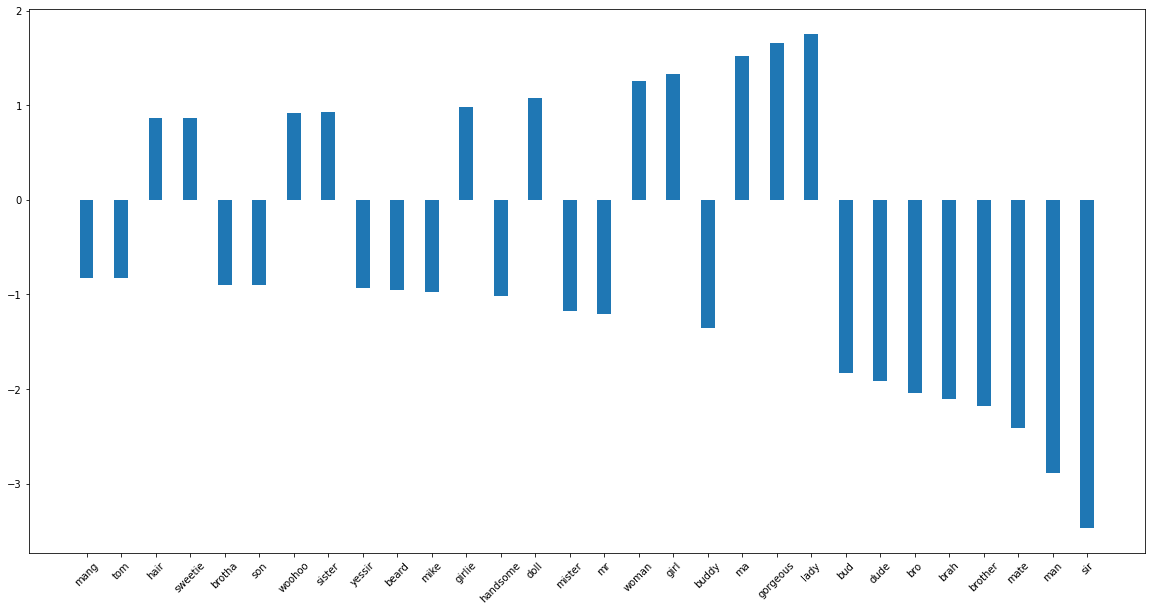

In [30]:
# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['features'][-30:], feature_importance['importance'][-30:], width = 0.4)
plt.xticks(rotation=45)
plt.show()

In [31]:
# visualize most freuquent words

In [32]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_df2['response_text_cleaned'])
features = vectorizer.get_feature_names_out()
y = data_df2['op_gender']

In [33]:
data_df2['responder_gender1'] = np.where(data_df2['responder_gender']=='W',0,1)
data_df2['responder_gender1']

0         1
1         0
2         1
3         0
4         1
         ..
318530    1
318531    0
318532    1
318533    1
318534    1
Name: responder_gender1, Length: 317577, dtype: int32

In [34]:

X_new = sparse.hstack((X,np.array(data_df2['responder_gender1'])[:,None]))

In [35]:
X.shape, X_new.shape

((317577, 53501), (317577, 53502))

In [36]:
feature1 = list(features) + ['responder gender']

In [37]:
X.shape, len(y), len(features1)

((317577, 53501), 317577, 53502)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

In [39]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.predict(X_train[:2, :]))
print(clf.predict_proba(X_train[:2, :]))
# >>> clf.score(X, y)

['M' 'M']
[[0.67094421 0.32905579]
 [0.62431556 0.37568444]]


In [40]:
y_train[:2]

275346    M
122205    W
Name: op_gender, dtype: object

In [41]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid = dict(penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.609533 using {'C': 1.0, 'penalty': 'l2'}
0.605035 (0.002317) with: {'C': 100, 'penalty': 'l2'}
0.605787 (0.001829) with: {'C': 10, 'penalty': 'l2'}
0.609533 (0.001680) with: {'C': 1.0, 'penalty': 'l2'}
0.609514 (0.001307) with: {'C': 0.1, 'penalty': 'l2'}
0.599250 (0.001305) with: {'C': 0.01, 'penalty': 'l2'}


In [42]:
test_pred = grid_result.predict(X_test)
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, test_pred)
print("test accuracy : ", test_acc)

test accuracy :  0.6077041249606396


In [43]:
all_pred = grid_result.predict(X_new)
from sklearn.metrics import accuracy_score
all_acc = accuracy_score(y, all_pred)
print("overall accuracy : ", all_acc)

overall accuracy :  0.6365102006757416


In [44]:
grid_result.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [45]:
# get importance
importance = grid_result.best_estimator_.coef_[0]
feature_importance = pd.DataFrame({"importance":importance, "features":features1})
feature_importance

,importance,features
0,1.086727,__
1,-0.165214,___
2,-0.367876,____
3,-0.236707,_____
4,0.218924,______
...,...,...
53497,0.000000,zzzzz
53498,-0.105797,zzzzzz
53499,0.133080,zzzzzzzz
53500,-0.122341,zzzzzzzzzzz


In [46]:
feature_importance.sort_values(['importance'],  key=abs, inplace=True)
feature_importance


,importance,features
25849,0.000000,kombat
23225,0.000000,inge
23227,0.000000,ingen
23229,0.000000,ingeschat
23248,0.000000,inhabit
...,...,...
5712,-4.981027,brah
28871,-5.202964,mate
6146,-6.087407,brother
28442,-8.591966,man


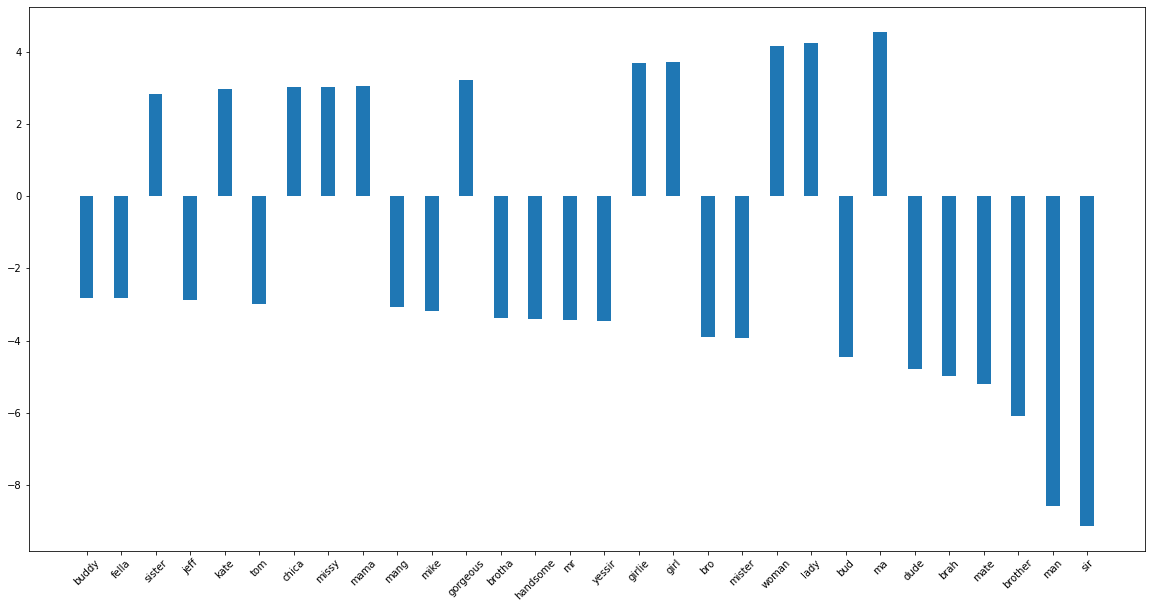

In [47]:
# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['features'][-30:], feature_importance['importance'][-30:], width = 0.4)
plt.xticks(rotation=45)
plt.show()

In [48]:
data_df1 = pd.read_csv("./preprocessed_data/fitness_posts_preprocssed_lem_stopwords_removal.csv")

In [49]:
data_df1

,Unnamed: 0,op_id,op_gender,post_id,post_text,post_text_cleaned,post_text_cleaned1
0,0,102,W,0,Thanks for the follow! I followed back :) I ...,thanks follow! followed back :) wanna kick but...,"['thanks', 'follow!', 'followed', 'back', ':)'..."
1,1,104,W,1,I've decided I have this crazy goal of running...,i've decided crazy goal running triathlon.,"[""i've"", 'decided', 'crazy', 'goal', 'running'..."
2,2,104,W,2,"Umm, yeah, so those are assisted pull-ups. Bef...","umm, yeah, assisted pull-ups. everyone start t...","['umm,', 'yeah,', 'assisted', 'pull-ups.', 'ev..."
3,3,117,M,3,dam gurl lookin mad tone in dat pp holla bb,dam gurl lookin mad tone dat pp holla bb,"['dam', 'gurl', 'lookin', 'mad', 'tone', 'dat'..."
4,4,117,M,4,What's up there bear mode?,what's bear mode?,"[""what's"", 'bear', 'mode?']"
...,...,...,...,...,...,...,...
318530,318530,1905641,M,318530,"ok, been lazy since I joined. made a promise t...","ok, lazy since joined. made promise sedentary ...","['ok,', 'lazy', 'since', 'joined.', 'made', 'p..."
318531,318531,1905641,M,318531,Need some verbal ass-kicking. The laziness is ...,need verbal ass-kicking. laziness strong today...,"['need', 'verbal', 'ass-kicking.', 'laziness',..."
318532,318532,1906277,W,318532,Thanks for the props!!,thanks props!!,"['thanks', 'props!!']"
318533,318533,1906415,W,318533,Hi Loolou! Welcome to Fitocracy! :) I have to ...,hi loolou! welcome fitocracy! :) ask... exerci...,"['hi', 'loolou!', 'welcome', 'fitocracy!', ':)..."


In [50]:
data_df2

,Unnamed: 0,op_id,op_gender,post_id,responder_id,response_text,responder_gender,response_text_cleaned,response_text_cleaned1,responder_gender1
0,0,102,W,0,1196122,One day at a time! =],M,one day time! =],"['one', 'day', 'time!', '=]']",1
1,1,104,W,1,5867,Crazy is synonymous with awesome in this case.,W,crazy synonymous awesome case.,"['crazy', 'synonymous', 'awesome', 'case.']",0
2,2,104,W,2,1635,You can enter assisted pullups. Select pullups...,M,enter assisted pullups. select pullups normall...,"['enter', 'assisted', 'pullups.', 'select', 'p...",1
3,3,117,M,3,8520,"Mirin 3% bodyfat? Yeah, you are.",W,"mirin % bodyfat? yeah, are.","['mirin', '%', 'bodyfat?', 'yeah,', 'are.']",0
4,4,117,M,4,29126,"Hey! I just started a new job, so things are s...",M,"hey! started new job, thing sorta hectic. let ...","['hey!', 'started', 'new', 'job,', 'thing', 's...",1
...,...,...,...,...,...,...,...,...,...,...
318530,318530,1905641,M,318530,786107,Let's go!!!GET IT DONE!!!,M,let's go!!!get done!!!,"[""let's"", 'go!!!get', 'done!!!']",1
318531,318531,1905641,M,318531,1633523,STACKHOUSE!! You have TWO a options: what you ...,W,stackhouse!! two options: want want most. choose.,"['stackhouse!!', 'two', 'options:', 'want', 'w...",0
318532,318532,1906277,W,318532,607842,You are welcome. Keep up the hard work!,M,welcome. keep hard work!,"['welcome.', 'keep', 'hard', 'work!']",1
318533,318533,1906415,W,318533,1665473,Because the calendar she uses was from a dolla...,M,calendar us dollar store missing monday tuesday.,"['calendar', 'us', 'dollar', 'store', 'missing...",1


In [52]:
data_df3 = data_df2.merge(data_df1, on=['op_id', 'post_id'])

In [53]:
data_df3

,Unnamed: 0_x,op_id,op_gender_x,post_id,responder_id,response_text,responder_gender,response_text_cleaned,response_text_cleaned1,responder_gender1,Unnamed: 0_y,op_gender_y,post_text,post_text_cleaned,post_text_cleaned1
0,0,102,W,0,1196122,One day at a time! =],M,one day time! =],"['one', 'day', 'time!', '=]']",1,0,W,Thanks for the follow! I followed back :) I ...,thanks follow! followed back :) wanna kick but...,"['thanks', 'follow!', 'followed', 'back', ':)'..."
1,1,104,W,1,5867,Crazy is synonymous with awesome in this case.,W,crazy synonymous awesome case.,"['crazy', 'synonymous', 'awesome', 'case.']",0,1,W,I've decided I have this crazy goal of running...,i've decided crazy goal running triathlon.,"[""i've"", 'decided', 'crazy', 'goal', 'running'..."
2,2,104,W,2,1635,You can enter assisted pullups. Select pullups...,M,enter assisted pullups. select pullups normall...,"['enter', 'assisted', 'pullups.', 'select', 'p...",1,2,W,"Umm, yeah, so those are assisted pull-ups. Bef...","umm, yeah, assisted pull-ups. everyone start t...","['umm,', 'yeah,', 'assisted', 'pull-ups.', 'ev..."
3,3,117,M,3,8520,"Mirin 3% bodyfat? Yeah, you are.",W,"mirin % bodyfat? yeah, are.","['mirin', '%', 'bodyfat?', 'yeah,', 'are.']",0,3,M,dam gurl lookin mad tone in dat pp holla bb,dam gurl lookin mad tone dat pp holla bb,"['dam', 'gurl', 'lookin', 'mad', 'tone', 'dat'..."
4,4,117,M,4,29126,"Hey! I just started a new job, so things are s...",M,"hey! started new job, thing sorta hectic. let ...","['hey!', 'started', 'new', 'job,', 'thing', 's...",1,4,M,What's up there bear mode?,what's bear mode?,"[""what's"", 'bear', 'mode?']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317572,318530,1905641,M,318530,786107,Let's go!!!GET IT DONE!!!,M,let's go!!!get done!!!,"[""let's"", 'go!!!get', 'done!!!']",1,318530,M,"ok, been lazy since I joined. made a promise t...","ok, lazy since joined. made promise sedentary ...","['ok,', 'lazy', 'since', 'joined.', 'made', 'p..."
317573,318531,1905641,M,318531,1633523,STACKHOUSE!! You have TWO a options: what you ...,W,stackhouse!! two options: want want most. choose.,"['stackhouse!!', 'two', 'options:', 'want', 'w...",0,318531,M,Need some verbal ass-kicking. The laziness is ...,need verbal ass-kicking. laziness strong today...,"['need', 'verbal', 'ass-kicking.', 'laziness',..."
317574,318532,1906277,W,318532,607842,You are welcome. Keep up the hard work!,M,welcome. keep hard work!,"['welcome.', 'keep', 'hard', 'work!']",1,318532,W,Thanks for the props!!,thanks props!!,"['thanks', 'props!!']"
317575,318533,1906415,W,318533,1665473,Because the calendar she uses was from a dolla...,M,calendar us dollar store missing monday tuesday.,"['calendar', 'us', 'dollar', 'store', 'missing...",1,318533,W,Hi Loolou! Welcome to Fitocracy! :) I have to ...,hi loolou! welcome fitocracy! :) ask... exerci...,"['hi', 'loolou!', 'welcome', 'fitocracy!', ':)..."


In [56]:
data_df3['total_text'] = data_df3['response_text_cleaned'] + data_df3['post_text_cleaned']
data_df3['total_text']

0         one day time! =]thanks follow! followed back :...
1         crazy synonymous awesome case.i've decided cra...
2         enter assisted pullups. select pullups normall...
3         mirin % bodyfat? yeah, are.dam gurl lookin mad...
4         hey! started new job, thing sorta hectic. let ...
                                ...                        
317572    let's go!!!get done!!!ok, lazy since joined. m...
317573    stackhouse!! two options: want want most. choo...
317574               welcome. keep hard work!thanks props!!
317575    calendar us dollar store missing monday tuesda...
317576    wait minute....welcome! thanks following! glad...
Name: total_text, Length: 317577, dtype: object

In [57]:
data_df3= data_df3[~data_df3['total_text'].isna()]

In [73]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_df3['total_text'])
features = vectorizer.get_feature_names_out()
y = data_df3['op_gender_y']

In [74]:
X.shape

(316964, 106561)

In [75]:
print(features[:30])

['__' '___' '____' '_____' '______' '_______' '________' '__________'
 '___________' '_____________' '______________' '_________________'
 '__________________' '________________________'
 '_________________________' '__________________________________'
 '____________________________________'
 '_________________________________________________________________________keep'
 '__it' '__seems' '_again_' '_alright' '_and_' '_any_' '_atlas_' '_awe_'
 '_back' '_bomb_' '_c' '_corona']


In [76]:
X.shape, len(y), len(features)

((316964, 106561), 316964, 106561)

In [77]:
type(X)

scipy.sparse._csr.csr_matrix

In [78]:
data_df2['responder_gender']

0         M
1         W
2         M
3         W
4         M
         ..
318530    M
318531    W
318532    M
318533    M
318534    M
Name: responder_gender, Length: 317577, dtype: object

In [79]:
data_df2['responder_gender1'] = np.where(data_df2['responder_gender']=='W',0,1)
data_df2['responder_gender1']

0         1
1         0
2         1
3         0
4         1
         ..
318530    1
318531    0
318532    1
318533    1
318534    1
Name: responder_gender1, Length: 317577, dtype: int32

In [80]:

X_new = sparse.hstack((X,np.array(data_df3['responder_gender1'])[:,None]))

In [81]:
X.shape, X_new.shape

((316964, 106561), (316964, 106562))

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

In [83]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.predict(X_train[:2, :]))
print(clf.predict_proba(X_train[:2, :]))
# >>> clf.score(X, y)

['M' 'W']
[[0.90785477 0.09214523]
 [0.42864548 0.57135452]]


In [84]:
y_train[:2]

36178    M
18781    W
Name: op_gender_y, dtype: object

In [85]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid = dict(penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.665124 using {'C': 0.1, 'penalty': 'l2'}
0.659949 (0.002601) with: {'C': 100, 'penalty': 'l2'}
0.660274 (0.001902) with: {'C': 10, 'penalty': 'l2'}
0.662185 (0.002689) with: {'C': 1.0, 'penalty': 'l2'}
0.665124 (0.003431) with: {'C': 0.1, 'penalty': 'l2'}
0.658442 (0.003439) with: {'C': 0.01, 'penalty': 'l2'}


In [86]:
test_pred = grid_result.predict(X_test)
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, test_pred)
print("test accuracy : ", test_acc)

test accuracy :  0.6692224591057276


In [87]:
all_pred = grid_result.predict(X_new)
from sklearn.metrics import accuracy_score
all_acc = accuracy_score(y, all_pred)
print("overall accuracy : ", all_acc)

overall accuracy :  0.6891697479839982


In [88]:
grid_result.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [89]:
features

array(['__', '___', '____', ..., 'zzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzz'], dtype=object)

In [90]:
features1 = list(features) + ['responder gender']
features1

['__',
 '___',
 '____',
 '_____',
 '______',
 '_______',
 '________',
 '__________',
 '___________',
 '_____________',
 '______________',
 '_________________',
 '__________________',
 '________________________',
 '_________________________',
 '__________________________________',
 '____________________________________',
 '_________________________________________________________________________keep',
 '__it',
 '__seems',
 '_again_',
 '_alright',
 '_and_',
 '_any_',
 '_atlas_',
 '_awe_',
 '_back',
 '_bomb_',
 '_c',
 '_corona',
 '_definitely_',
 '_do_',
 '_don',
 '_everyday',
 '_everywhere_',
 '_exactly_',
 '_excuse_',
 '_fabulous_',
 '_fantastic_',
 '_fluff_',
 '_great_',
 '_have_',
 '_hot_',
 '_i_',
 '_idea_',
 '_insane_',
 '_is_',
 '_jenny_',
 '_jo_',
 '_just_',
 '_kev_',
 '_know_',
 '_little',
 '_loud_',
 '_manimal_',
 '_marajade',
 '_maz_',
 '_me_',
 '_merica_',
 '_morien_',
 '_my_',
 '_not_',
 '_o_o_',
 '_out_',
 '_paula_p_',
 '_really_',
 '_registered_',
 '_rolled_',
 '_shanti_',


In [91]:
# get importance
importance = grid_result.best_estimator_.coef_[0]
feature_importance = pd.DataFrame({"importance":importance, "features":features1})
feature_importance

,importance,features
0,0.578564,__
1,0.389121,___
2,0.117588,____
3,-0.092522,_____
4,-0.025302,______
...,...,...
106557,-0.018860,zzzzzzzzzzzzzzz
106558,0.000000,zzzzzzzzzzzzzzzzzzz
106559,0.028674,zzzzzzzzzzzzzzzzzzzzz
106560,0.028188,zzzzzzzzzzzzzzzzzzzzzz


In [92]:
feature_importance.sort_values(['importance'],  key=abs, inplace=True)
feature_importance


,importance,features
106408,0.000000,zombo
56621,0.000000,mainstay
24739,0.000000,doenbaar
80276,0.000000,sanitized
24737,0.000000,doem
...,...,...
11079,-1.985018,brah
12366,-2.065752,bud
56841,-2.075261,man
3318,3.498521,angel


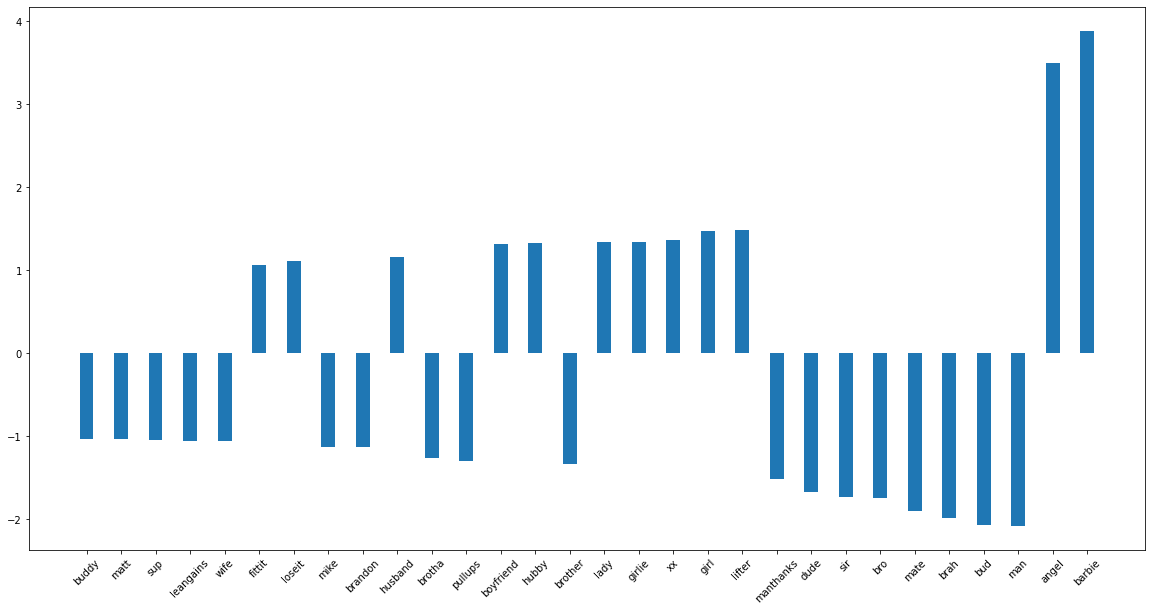

In [93]:
# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['features'][-30:], feature_importance['importance'][-30:], width = 0.4)
plt.xticks(rotation=45)
plt.show()

In [94]:
# visualize most freuquent words

In [96]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_df2['response_text_cleaned'])
features = vectorizer.get_feature_names_out()
y = data_df2['op_gender']

X.shape

print(features[:30])

X.shape, len(y), len(features)

type(X)

data_df2['responder_gender']

data_df2['responder_gender1'] = np.where(data_df2['responder_gender']=='W',0,1)
data_df2['responder_gender1']



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.predict(X_train[:2, :]))
print(clf.predict_proba(X_train[:2, :]))
# >>> clf.score(X, y)

y_train[:2]

from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid = dict(penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

test_pred = grid_result.predict(X_test)
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, test_pred)
print("test accuracy : ", test_acc)

all_pred = grid_result.predict(X)
from sklearn.metrics import accuracy_score
all_acc = accuracy_score(y, all_pred)
print("overall accuracy : ", all_acc)

grid_result.best_params_

features

features1 = list(features) + ['responder gender']
features1

nt words

['__' '___' '____' '_____' '______' '_______' '________' '__________'
 '______________' '__________________' '________________________' '__it'
 '_and_' '_c' '_corona' '_definitely_' '_do_' '_everyday' '_have_' '_hot_'
 '_i_' '_insane_' '_is_' '_know_' '_maz_' '_me_' '_not_' '_out_'
 '_paula_p_' '_something_']
['M' 'M']
[[0.59554186 0.40445814]
 [0.63929682 0.36070318]]
Best: 0.587806 using {'C': 0.1, 'penalty': 'l2'}
0.581649 (0.001103) with: {'C': 100, 'penalty': 'l2'}
0.582143 (0.001634) with: {'C': 10, 'penalty': 'l2'}
0.584540 (0.001099) with: {'C': 1.0, 'penalty': 'l2'}
0.587806 (0.001634) with: {'C': 0.1, 'penalty': 'l2'}
0.583623 (0.002509) with: {'C': 0.01, 'penalty': 'l2'}
test accuracy :  0.5865974561311438
overall accuracy :  0.6063379904716022


ValueError: All arrays must be of the same length

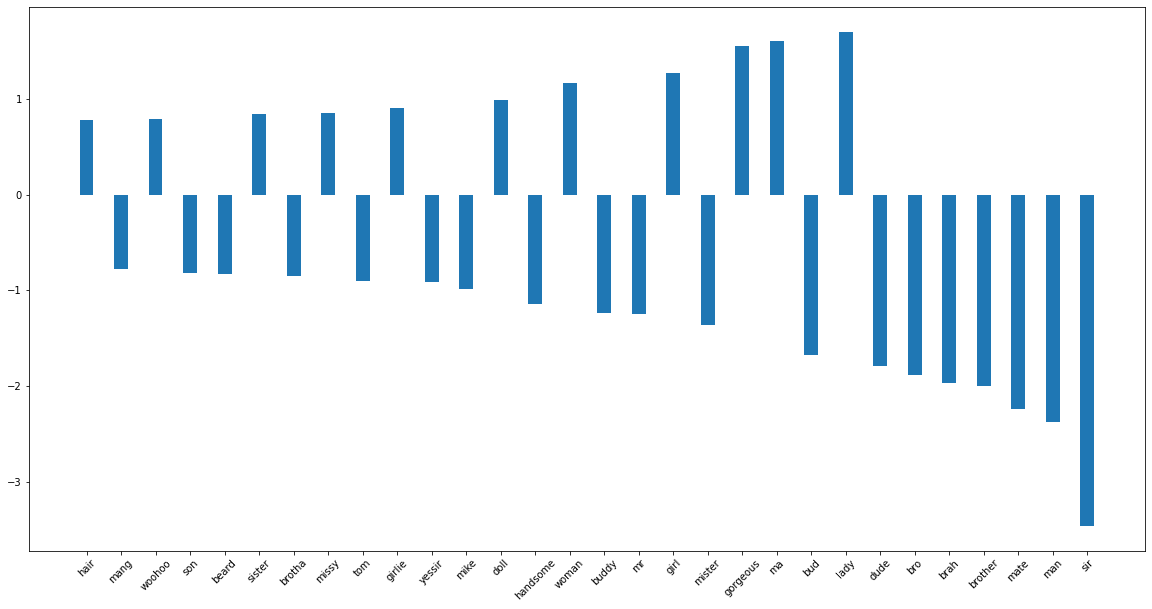

In [97]:
# get importance
importance = grid_result.best_estimator_.coef_[0]
feature_importance = pd.DataFrame({"importance":importance, "features":features})
feature_importance

feature_importance.sort_values(['importance'],  key=abs, inplace=True)
feature_importance


# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['features'][-30:], feature_importance['importance'][-30:], width = 0.4)
plt.xticks(rotation=45)
plt.show()

# visualize most freuque